In [143]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, getpass

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'finger_individuation')
dataDir = os.path.join(baseDir, 'data')
analysisDir = os.path.join(baseDir, 'analysis')


max arduino interval: 6, min: 5
max psychopy transmit interval: 14.1571, min: 0.0525
mean flip time: 16.7149, min: 14.5190, max: 33.7329


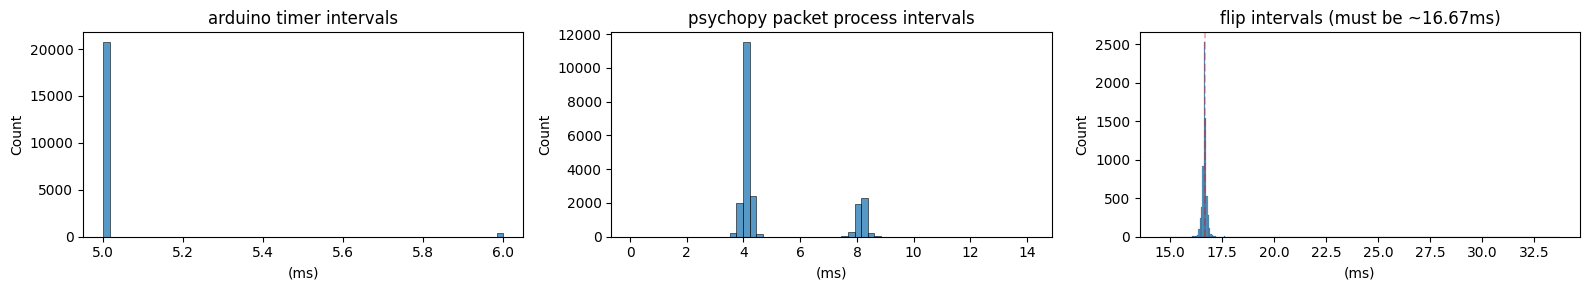

In [169]:
D = pd.read_csv(os.path.join(dataDir, 'test_01_20250912_161142.csv'))
debug = pd.read_csv(os.path.join(dataDir, 'test_01_debug_20250912_161142.csv'))
# print(np.where(debug.frame_time.values*1000 > 50))
# debug.frame_time[debug.frame_time.values*1000 > 50] = np.nan

# time sent by arduino
arduino_time = D.arduino_time.values
arduino_intervals = np.diff(arduino_time)
arduino_intervals[arduino_intervals>3000] = 5
print(f'max arduino interval: {np.max(arduino_intervals)}, min: {np.min(arduino_intervals)}')

# psychopy time at processing the packet
psy_time = D.psychopy_time.values
psy_intervals = np.diff(psy_time)*1000  # convert to ms
psy_intervals[psy_intervals>1000] = 5
print(f'max psychopy transmit interval: {np.max(psy_intervals):.4f}, min: {np.min(psy_intervals):.4f}')

# flip time of psychopy window
flip_time = np.diff(debug.flip_time.values)*1000
# flip_time[0] = 16

# histogram
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(16, 3))
sns.histplot(arduino_intervals, bins=61, ax=ax[0])
ax[0].set_title('arduino timer intervals')
ax[0].set_xlabel('(ms)')

sns.histplot(psy_intervals, bins=61, ax=ax[1])
ax[1].set_title('psychopy packet process intervals')
ax[1].set_xlabel('(ms)')

ax[2].axvline(16.67, color='r', linestyle='--', alpha=0.3)
sns.histplot(flip_time, bins=301, ax=ax[2])
ax[2].set_title('flip intervals (must be ~16.67ms)')
ax[2].set_xlabel('(ms)')

print(f'mean flip time: {np.nanmean(flip_time):.4f}, min: {np.min(flip_time):.4f}, max: {np.max(flip_time):.4f}')

plt.tight_layout()
plt.show()




# latency check

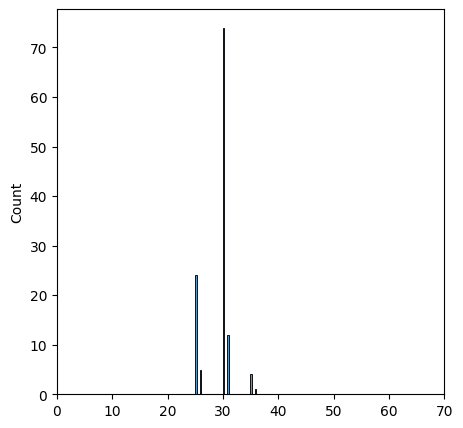

120 120
mean latency: 29.1500ms +- 2.4855ms STD


In [162]:
# clean up the photodiode signal:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from scipy.signal import medfilt
from scipy.ndimage import binary_opening

def _odd_kernel(samples: int) -> int:
    k = int(max(1, samples))
    return k if k % 2 == 1 else k + 1

def hampel_filter(x, fs, window_ms=20.0, n_sigmas=3.0):
    """
    Robust outlier replace: replace spikes deviating > n_sigmas * (1.4826*MAD)
    from the local median within a window. Returns (y, outlier_idx).
    """
    x = np.asarray(x).astype(float)
    k = _odd_kernel(round(window_ms * fs / 1000.0))
    half = k // 2
    # Pad at edges to keep length
    padded = np.pad(x, (half, half), mode='edge')
    windows = sliding_window_view(padded, k)  # shape (N, k)
    med = np.median(windows, axis=1)
    mad = np.median(np.abs(windows - med[:, None]), axis=1)
    sigma = 1.4826 * mad  # convert MAD to robust sigma
    outliers = np.abs(x - med) > (n_sigmas * np.maximum(sigma, 1e-12))
    y = x.copy()
    y[outliers] = med[outliers]
    return y, np.flatnonzero(outliers)

def median_denoise(x, fs, window_ms=9.0):
    """
    Median filter denoising with an odd kernel derived from window_ms.
    """
    x = np.asarray(x).astype(float)
    k = _odd_kernel(round(window_ms * fs / 1000.0))
    return medfilt(x, kernel_size=k)

def remove_short_nonzero_runs(x, fs, glitch_max_ms=10.0, amp_thresh=0.0):
    """
    Morphological opening on a binary mask of |x| > amp_thresh to erase
    nonzero runs shorter than glitch_max_ms. Returns (y, removed_idx).
    """
    x = np.asarray(x).astype(float)
    mask = np.abs(x) > amp_thresh
    se_len = max(1, int(round(glitch_max_ms * fs / 1000.0)))
    structure = np.ones(se_len, dtype=bool)
    opened = binary_opening(mask, structure=structure)
    removed = mask & (~opened)  # short runs removed by opening
    y = x.copy()
    y[removed] = 0.0
    return y, np.flatnonzero(removed)

def clean_signal(
    x, fs,
    method="hampel",
    glitch_max_ms=10.0,
    gap_ms=300.0,
    pulse_ms=500.0,
    n_sigmas=3.0,
    window_ms=None,
    amp_thresh=0.0
):
    """
    Wrapper choosing a cleaning strategy:
      - method='hampel': robust outlier replacement
      - method='median': median filter
      - method='morph': remove short nonzero runs via morphology
    If window_ms is None, it is set based on glitch_max_ms.
    """
    if window_ms is None:
        window_ms = max(3.0, float(glitch_max_ms))  # small window targeting glitches

    if method.lower() == "hampel":
        y, idx = hampel_filter(x, fs, window_ms=window_ms, n_sigmas=n_sigmas)
    elif method.lower() == "median":
        y = median_denoise(x, fs, window_ms=window_ms)
        idx = np.array([], dtype=int)  # median doesn't explicitly flag indices
    elif method.lower() in ("morph", "morphology", "opening"):
        y, idx = remove_short_nonzero_runs(x, fs, glitch_max_ms=glitch_max_ms, amp_thresh=amp_thresh)
    else:
        raise ValueError("method must be 'hampel', 'median', or 'morph'")

    return y, idx

D = pd.read_csv(os.path.join(dataDir, 'test_01_20250912_161142.csv'))
debug = pd.read_csv(os.path.join(dataDir, 'test_01_debug_20250912_161142.csv'))

fs = 200  # Hz
# y_morph, removed_idx = clean_signal(D.l3.values, fs, method="morph", glitch_max_ms=40, amp_thresh=0.1)
# D.l3 = y_morph
# print(removed_idx)

state = D.state.values

idx = np.int64(state=='EXECUTION')
idx = np.int64(np.diff(idx.astype(int))==1)
idx = np.concatenate(([0], idx))
idx = np.where(idx==1)[0]
go_onset = D.arduino_time[idx].values

# fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(110, 10))
# plt.plot(D.arduino_time,D.l3, lw=0.3)
# for vline in go_onset:
#     ax.axvline(vline, label='arduino time', color='r', alpha=1, lw=0.5, ls='--')

# # save figure
# fig.savefig(os.path.join('./latency_check.pdf'), dpi=300)

# detect photodiode signal onset:
photodiode = D.l3.values
idx = np.int64(photodiode < 1023)
idx = np.diff(idx)
idx = np.concatenate(([0], idx))
signal_onset = D.arduino_time[np.where(idx==1)[0]].values

# compute latency
latency = signal_onset - go_onset
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(5, 5))
sns.histplot(latency, bins=40, ax=ax)
ax.set_xlim(0, 70)
plt.show()

print(len(signal_onset), len(go_onset))

# a = np.diff(signal_onset)
# signal_onset

print(f'mean latency: {np.mean(latency):.4f}ms +- {np.std(latency):.4f}ms STD')


